In [1]:
import pandas as pd
from pandas import DataFrame
import datetime
import re
from sets import Set
#import pandas.io.data
import numpy as np
from itertools import izip
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#print(plt.style.available)
plt.style.use('ggplot')
import random
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# def isMatched(macula_find_list,regex):
# #	print macula_find_list
# 	for i in (macula_find_list):
# 		i = str(i)
# 		for j in (regex):
# #			print type(j)
# #			print i +"-----------" + j
# 			if(re.search(j,i,re.IGNORECASE)):
# 				return True
# 	return False

# # NPDR Related Regular Expression
# regex_back_type1 = ["type 1"]
# regex_back_type2 = ["type 2"]

all_icd_for_patients = {}
all_snomed_for_patients = {}

table_names = ['all_encounter_data', 'demographics', 'encounters', 'family_hist_for_Enc',
 'family_hist_list', 'ICD_for_Enc', 'ICD_list', 'macula_findings_for_Enc',
 'SL_Lens_for_Enc', 'SNOMED_problem_list', 'systemic_disease_for_Enc', 'systemic_disease_list']

path ='/Users/vinodrao/MATH497/allPickles/'
dfs = [pd.read_pickle(path + name + '.pickle') if name != 'ICD_list' else None 
       for name in table_names]

systemic=dfs[10]
#snomed_list=dfs[9]

#icd.head()
latest_encounter=pd.read_csv('/Users/vinodrao/MATH497/allPickles/LatestEncounter3.csv')
person_nbr=latest_encounter['Person_Nbr']
last_enc_number=latest_encounter['Enc_Nbr']

icd=dfs[5]
#icd.head()

'''
for index, row in icd.iterrows():
    p_nbr = row['Person_Nbr']
    icd_code = re.sub(r'\.', '', row['Diagnosis_Code_ID'])
    all_icd_for_patients.setdefault(p_nbr, {})[icd_code]=1

for index, row in snomed_list.iterrows():
    p_nbr = row['Person_Nbr']
    snomed_code = row['Concept_ID']
    all_snomed_for_patients.setdefault(p_nbr, {})[snomed_code]=1
'''

all_person_nbr = person_nbr    
person_nbr=np.unique(icd['Person_Nbr'])

#These ICD have to be according to Diabetes Types
#vision_threatning=['362.02','E10.351','E10.359','E11.351','E11.359','E13.351','E13.359','E10.352','E10.353',' E10.354', 'E10.355','E11.352',' E11.353','E11.354','E11.355'
#                   ,'362.06','E10.341','E10.349','E11.341','E11.349','E13.341','E13.349']
#non_vision_threatning=['362.04','E10.321','E10.329','E11.321','E11.329','E13.321','E13.329','362.03'
#                       ,'362.05','E10.331','E10.339','E11.331','E11.339','E13.331','E13.339'
#                       ,'362.01','E10.311','E10.319','E11.311','E11.319','E13.311','E13.319']

non_vision_threatning='E1031*|E1032*|E1033*|E1131*|E1132*|E1133*|E1331*|E1332*|E1333*|36201|36203|36204|36205|2505*'

vision_threatning='E1034*|E1035*|E1134*|E1135*|E1334*|E1335*|36202|36206'

vision_threat_snomed=Set(['59276001' , '232021008' , '232022001' , '312905005' , '312906006' , '312907002' , '312908007' , '312909004' , '399862001' , '399863006' , '399872003' , '399873008' , '399874002' , '399876000' , '399877009' , '408413000' , '1501000119109' , '60971000119101' , '97341000119105' , '103981000119101' , '430801000124103'])
non_vision_threat_snomed=Set(['4855003' , '193349004' , '312903003' , '312904009' , '312905005' , '390834004' , '399875001' , '408311002' , '408385003' , '408409007' , '408410002' , '408412005' , '420789003' , '422034002' , '706894000' , '1551000119108' , '60961000119107' , '97331000119101' , '138911000119106' , '138921000119104'])

#dr_background=[]

#PDR % Severe NPDR
all_vision_threatning=[]

# Mild and Moderate NPDR, DM_Background
all_non_vision_threatning=[]

#NO DR
target_dm_noDR=[]

for i in range(len(last_enc_number)):
    #icd_nmbrs=icd.loc[icd['Person_Nbr'] == person_nbr[i]]['Diagnosis_Code_ID'].values
    #get person number
    #print all_person_nbr[i]
    #all_icds = all_icd_for_patients.get(all_person_nbr[i], {}).keys( )
    #all_snomeds = all_snomed_for_patients.get(all_person_nbr[i], {}).keys( )
    
    #snomed_codes = snomed_list.loc[snomed_list['Enc_Nbr']==last_enc_number[i]]['Concept_ID'].values
    icd_nmbrs = icd.loc[icd['Enc_Nbr']==last_enc_number[i]]['Diagnosis_Code_ID'].values
    snomed_codes = systemic.loc[systemic['Enc_Nbr']==last_enc_number[i]]['Snomed_Code'].values
    flag = False
    
    #for icds in all_icds:
    for icds in icd_nmbrs:
        icds = re.sub(r'\.', '', icds)
        if bool(re.match(vision_threatning,icds)):    
            all_vision_threatning.append(last_enc_number[i])
            latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=1
            flag = True
            break
    
    if flag == False:
        #for icds in all_icds:
        for icds in icd_nmbrs:
            icds = re.sub(r'\.', '', icds)
            if bool(re.match(non_vision_threatning,icds)):
                all_non_vision_threatning.append(last_enc_number[i])
                latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=2
                flag = True
                break
                  
    if flag == False:
        for snomeds in snomed_codes:
            if len(snomeds) > 0 and snomeds in vision_threat_snomed:
                all_vision_threatning.append(last_enc_number[i])
                latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=1
                flag = True
                break
                
    if flag == False:           
        for snomeds in snomed_codes:
            if len(snomeds) > 0 and snomeds in non_vision_threat_snomed:
                all_non_vision_threatning.append(last_enc_number[i])
                latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=2
                flag = True
                break
    
    if flag == False:
        target_dm_noDR.append(last_enc_number[i])
        latest_encounter.loc[latest_encounter['Enc_Nbr']==last_enc_number[i],'target_class']=3


/Users/vinodrao/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: the sets module is deprecated


In [2]:
latest_encounter['BMI_Missing'] = pd.Series([1]*len(latest_encounter['BMI']), index=latest_encounter.index)
latest_encounter['BP_Upper_Missing'] = pd.Series([1]*len(latest_encounter['BP_Upper']), index=latest_encounter.index)
latest_encounter['BP_Lower_Missing'] = pd.Series([1]*len(latest_encounter['BP_Lower']), index=latest_encounter.index)
latest_encounter['A1C_Missing'] = pd.Series([1]*len(latest_encounter['A1C']), index=latest_encounter.index)
latest_encounter['Glucose_Missing'] = pd.Series([1]*len(latest_encounter['Glucose']), index=latest_encounter.index)

latest_encounter.head()

,Unnamed: 0,Enc_ID,Enc_Nbr,Enc_Date,Person_ID,Person_Nbr,Primary_Payer,Smoking_Status,BMI,BP,...,CYCLO_OS_DVA,CYCLO_OS_NVA,BP_Upper,BP_Lower,target_class,BMI_Missing,BP_Upper_Missing,BP_Lower_Missing,A1C_Missing,Glucose_Missing
0,75858,97825c51-4462-eade-1c1d-2baa3400c033,123227,2014-12-18 14:00:00.000,80d3df88-dddf-5ad3-7cc1-b7b1ac6151fa,33,Premier Vision Plan,Never smoker,NaN,118/ 78,...,NaN,NaN,118.0,78.0,2.0,1,1,1,1,1
1,55355,63d5135e-abdc-ecfa-3183-3cb6e3821f23,233159,2016-10-22 11:29:08.763,adca6fa4-e7d4-d7f8-cf41-27056662d84b,89,Adv BCBS HMO,Former smoker,27.685,NaN,...,NaN,NaN,92.0,53.0,3.0,1,1,1,1,1
2,45226,63ecc259-208f-7ef2-b0f8-acf25e23c264,5786173,2016-04-05 10:15:00.000,ca793eec-f101-2505-42e6-57fefc6baf14,146,Medicare,Former smoker,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,1,1,1,1,1
3,83126,6d7eb129-dbd7-3b56-99ee-61da920c63fa,3432515,2016-10-10 15:03:52.093,3afb193c-dbf7-9f64-5f95-447f81cd0bdf,196,EyeQuest Family Health Network,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,1,1,1,1,1
4,11443,1111f300-d5ec-474c-6089-7d45df0a4147,14361139,2011-12-04 11:00:00.000,df427511-5c09-d4c0-1571-daa28d11a3b7,327,Medicare,Never smoker,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,1,1,1,1,1


In [3]:
latest_encounter.loc[pd.isnull(latest_encounter['BMI'])==True,'BMI_Missing']=0
latest_encounter.loc[pd.isnull(latest_encounter['BP_Upper'])==True,'BP_Upper_Missing']=0
latest_encounter.loc[pd.isnull(latest_encounter['BP_Lower'])==True,'BP_Lower_Missing']=0
latest_encounter.loc[pd.isnull(latest_encounter['A1C'])==True,'A1C_Missing']=0
latest_encounter.loc[pd.isnull(latest_encounter['Glucose'])==True,'Glucose_Missing']=0

In [4]:
import warnings
warnings.filterwarnings('ignore')
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.18.1.


In [5]:
#### vision_threatning Null values cleaning

# v_t_data = latest_encounter[last_enc_number.isin(all_vision_threatning)]
# Null_bpL_pdr_index = v_t_data[v_t_data.BP_Lower.isnull()].index
# Null_bpU_pdr_index = v_t_data[v_t_data.BP_Upper.isnull()].index
# Null_bmi_pdr_index = v_t_data[v_t_data.BMI.isnull()].index
# Null_glu_pdr_index = v_t_data[v_t_data.Glucose.isnull()].index
# Null_a1c_pdr_index = v_t_data[v_t_data.A1C.isnull()].index
# latest_encounter.BP_Lower[Null_bpL_pdr_index.values] = v_t_data.BP_Lower.mean()
# latest_encounter.BP_Upper[Null_bpU_pdr_index.values] = v_t_data.BP_Upper.mean()
# latest_encounter.BMI[Null_bmi_pdr_index.values] = v_t_data.BMI.mean()
# latest_encounter.Glucose[Null_glu_pdr_index.values] = v_t_data.Glucose.mean()
# latest_encounter.A1C[Null_a1c_pdr_index.values] = v_t_data.A1C.mean()
# print(latest_encounter.A1C.isnull().sum())
# print(latest_encounter.Glucose.isnull().sum())
# #print(latest_encounter.Glucose.isnan().sum())
# print(latest_encounter.BP_Lower.isnull().sum())
# print(latest_encounter.BP_Upper.isnull().sum())
# print(latest_encounter.BMI.isnull().sum())


In [6]:
# #### NPDR_Severe Null values cleaning

# non_v_t_data = latest_encounter[last_enc_number.isin(all_non_vision_threatning)]
# Null_bpL_npdr_s_index = non_v_t_data[non_v_t_data.BP_Lower.isnull()].index
# Null_bpU_npdr_s_index = non_v_t_data[non_v_t_data.BP_Upper.isnull()].index
# Null_bmi_npdr_s_index = non_v_t_data[non_v_t_data.BMI.isnull()].index
# Null_glu_npdr_s_index = non_v_t_data[non_v_t_data.Glucose.isnull()].index
# Null_a1c_npdr_s_index = non_v_t_data[non_v_t_data.A1C.isnull()].index
# latest_encounter.BP_Lower[Null_bpL_npdr_s_index.values] = non_v_t_data.BP_Lower.mean()
# latest_encounter.BP_Upper[Null_bpU_npdr_s_index.values] = non_v_t_data.BP_Upper.mean()
# latest_encounter.BMI[Null_bmi_npdr_s_index.values] = non_v_t_data.BMI.mean()
# latest_encounter.Glucose[Null_glu_npdr_s_index.values] = non_v_t_data.Glucose.mean()
# latest_encounter.A1C[Null_a1c_npdr_s_index.values] = non_v_t_data.A1C.mean()
# print(latest_encounter.A1C.isnull().sum())
# print(latest_encounter.BP_Lower.isnull().sum())


In [7]:
# #### DM_noDR Null values cleaning

# dm_noDR_data = latest_encounter[last_enc_number.isin(target_dm_noDR)]
# Null_bpL_noDR_index = dm_noDR_data[dm_noDR_data.BP_Lower.isnull()].index
# Null_bpU_noDR_index = dm_noDR_data[dm_noDR_data.BP_Upper.isnull()].index
# Null_bmi_noDR_index = dm_noDR_data[dm_noDR_data.BMI.isnull()].index
# Null_glu_noDR_index = dm_noDR_data[dm_noDR_data.Glucose.isnull()].index
# Null_a1c_noDR_index = dm_noDR_data[dm_noDR_data.A1C.isnull()].index
# latest_encounter.BP_Lower[Null_bpL_noDR_index.values] = dm_noDR_data.BP_Lower.mean()
# latest_encounter.BP_Upper[Null_bpU_noDR_index.values] = dm_noDR_data.BP_Upper.mean()
# latest_encounter.BMI[Null_bmi_noDR_index.values] = dm_noDR_data.BMI.mean()
# latest_encounter.Glucose[Null_glu_noDR_index.values] = dm_noDR_data.Glucose.mean()
# latest_encounter.A1C[Null_a1c_noDR_index.values] = dm_noDR_data.A1C.mean()
# print(latest_encounter.A1C.isnull().sum())


In [8]:
cols =[latest_encounter.BMI.dropna(),latest_encounter.Glucose.dropna(),latest_encounter.A1C.dropna(),latest_encounter.BP_Lower.dropna(),latest_encounter.BP_Upper.dropna()]
High = []
Low = []
from scipy.stats import iqr
for i in cols:
    Q1 = np.percentile(i,5)
    Q3 = np.percentile(i,95)
    High.append(Q3 + 1.5*iqr(i))
    Low.append(Q1 - 1.5*iqr(i))
    print i.name,"\n",Q1,Q3,"\n",Low,High
print Low,"\n" ,High
temp_latest_encounter=latest_encounter
latest_encounter.loc[temp_latest_encounter['BMI']<Low[0],'BMI']=Low[0]
latest_encounter.loc[temp_latest_encounter['BMI']>High[0],'BMI']=High[0]

latest_encounter.loc[temp_latest_encounter['Glucose']<Low[1],'Glucose']=Low[1]
latest_encounter.loc[temp_latest_encounter['Glucose']>High[1],'Glucose']=High[1]

latest_encounter.loc[temp_latest_encounter['A1C']<Low[2],'A1C']=Low[2]
latest_encounter.loc[temp_latest_encounter['A1C']>High[2],'A1C']=High[2]

latest_encounter.loc[temp_latest_encounter['BP_Upper']<Low[3],'BP_Upper']=Low[3]
latest_encounter.loc[temp_latest_encounter['BP_Upper']>High[3],'BP_Upper']=High[3]

latest_encounter.loc[temp_latest_encounter['BP_Lower']<Low[3],'BP_Lower']=Low[4]
latest_encounter.loc[temp_latest_encounter['BP_Lower']>High[3],'BP_Lower']=High[4]

BMI 
21.9865 48.06 
[7.2865000000000038] [62.759999999999998]
Glucose 
80.0 238.0 
[7.2865000000000038, 3.5] [62.759999999999998, 314.5]
A1C 
4.0 11.0 
[7.2865000000000038, 3.5, 1.3000000000000003] [62.759999999999998, 314.5, 13.699999999999999]
BP_Lower 
59.0 98.0 
[7.2865000000000038, 3.5, 1.3000000000000003, 36.5] [62.759999999999998, 314.5, 13.699999999999999, 120.5]
BP_Upper 
104.0 170.0 
[7.2865000000000038, 3.5, 1.3000000000000003, 36.5, 68.0] [62.759999999999998, 314.5, 13.699999999999999, 120.5, 206.0]
[7.2865000000000038, 3.5, 1.3000000000000003, 36.5, 68.0] 
[62.759999999999998, 314.5, 13.699999999999999, 120.5, 206.0]


In [9]:
latest_encounter.BP_Lower[latest_encounter.BP_Lower.isnull()] = 0
latest_encounter.BP_Upper[latest_encounter.BP_Upper.isnull()] = 0
latest_encounter.BMI[latest_encounter.BMI.isnull()] = 0
latest_encounter.Glucose[latest_encounter.Glucose.isnull()] = 0
latest_encounter.A1C[latest_encounter.A1C.isnull()] = 0

In [10]:
latest_encounter.A1C.isnull().sum()

0

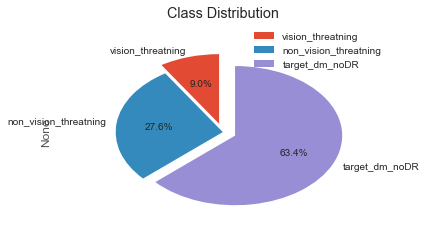

In [11]:
classes = [all_vision_threatning,all_non_vision_threatning,target_dm_noDR]
classes_name = ['vision_threatning','non_vision_threatning','target_dm_noDR']
classes_dict = {}
for x in range(len(classes)):
    name = classes_name[x]
    freq = len(classes[x])
    classes_dict[name]= freq
s = pd.Series(data=classes_dict.values(),
index = classes_dict.keys())
ax = s.plot.pie(autopct='%1.1f%%',startangle=90,explode=(0.1,0,0.1), radius = 0.8)
ax.set_title('Class Distribution')
ax.legend()

In [12]:
latest_encounter.columns
# len(latest_encounter.Person_Nbr.unique())

Index([u'Unnamed: 0', u'Enc_ID', u'Enc_Nbr', u'Enc_Date', u'Person_ID',
       u'Person_Nbr', u'Primary_Payer', u'Smoking_Status', u'BMI', u'BP',
       u'Glucose', u'A1C', u'MR_OD_SPH', u'MR_OD_CYL', u'MR_OD_AXIS',
       u'MR_OD_DVA', u'MR_OD_NVA', u'MR_OS_SPH', u'MR_OS_CYL', u'MR_OS_AXIS',
       u'MR_OS_DVA', u'MR_OS_NVA', u'BB_OD_SPH', u'BB_OD_CYL', u'BB_OD_AXIS',
       u'BB_OD_DVA', u'BB_OD_NVA', u'BB_OS_SPH', u'BB_OS_CYL', u'BB_OS_AXIS',
       u'BB_OS_DVA', u'BB_OS_NVA', u'CYCLO_OD_SPH', u'CYCLO_OD_CYL',
       u'CYCLO_OD_AXIS', u'CYCLO_OD_DVA', u'CYCLO_OD_NVA', u'CYCLO_OS_SPH',
       u'CYCLO_OS_CYL', u'CYCLO_OS_AXIS', u'CYCLO_OS_DVA', u'CYCLO_OS_NVA',
       u'BP_Upper', u'BP_Lower', u'target_class', u'BMI_Missing',
       u'BP_Upper_Missing', u'BP_Lower_Missing', u'A1C_Missing',
       u'Glucose_Missing'],
      dtype='object')

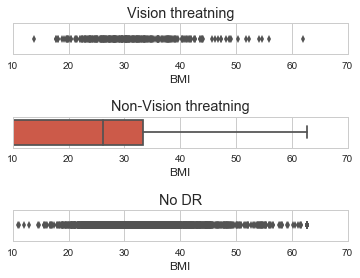

In [13]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
bmi1 = latest_encounter.BMI[latest_encounter.target_class == 1]
BMI1 = sns.boxplot(bmi1)
BMI1.set(xlim=(10, 70))
BMI1.set_title('Vision threatning')
plt.subplot(312)
bmi2 = latest_encounter.BMI[latest_encounter.target_class == 2]
BMI2 = sns.boxplot(bmi2)
BMI2.set(xlim=(10, 70))
BMI2.set_title('Non-Vision threatning')
plt.subplot(313)
bmi3 = latest_encounter.BMI[latest_encounter.target_class == 3]
BMI3 = sns.boxplot(bmi3)
BMI3.set(xlim=(10, 70))
BMI3.set_title('No DR')


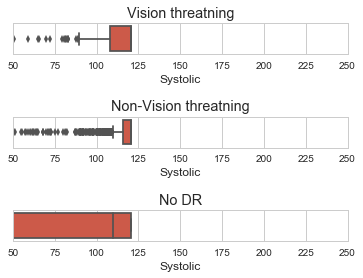

In [14]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
bpu1 = latest_encounter.BP_Upper[latest_encounter.target_class == 1]
BPU1 = sns.boxplot(bpu1)
BPU1.set(xlim=(50, 250))
BPU1.set_title('Vision threatning')
BPU1.set_xlabel('Systolic')
plt.subplot(312)
bpu2 = latest_encounter.BP_Upper[latest_encounter.target_class == 2]
BPU2 = sns.boxplot(bpu2)
BPU2.set(xlim=(50, 250))
BPU2.set_title('Non-Vision threatning')
BPU2.set_xlabel('Systolic')
plt.subplot(313)
bpu3 = latest_encounter.BP_Upper[latest_encounter.target_class == 3]
BPU3 = sns.boxplot(bpu3)
BPU3.set(xlim=(50, 250))
BPU3.set_title('No DR')
BPU3.set_xlabel('Systolic')

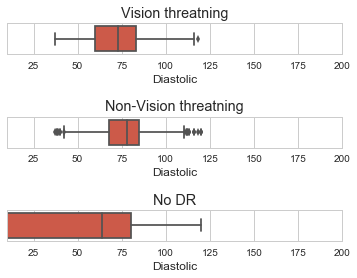

In [15]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
bpl1 = latest_encounter.BP_Lower[latest_encounter.target_class == 1]
BPL1 = sns.boxplot(bpl1)
BPL1.set(xlim=(10, 200))
BPL1.set_title('Vision threatning')
BPL1.set_xlabel('Diastolic')
plt.subplot(312)
bpl2 = latest_encounter.BP_Lower[latest_encounter.target_class == 2]
BPL2 = sns.boxplot(bpl2)
BPL2.set(xlim=(10, 200))
BPL2.set_title('Non-Vision threatning')
BPL2.set_xlabel('Diastolic')
plt.subplot(313)
bpl3 = latest_encounter.BP_Lower[latest_encounter.target_class == 3]
BPL3 = sns.boxplot(bpl3)
BPL3.set(xlim=(10, 200))
# BPU3.set(xlim=(10, 70))
BPL3.set_title('No DR')
BPL3.set_xlabel('Diastolic')

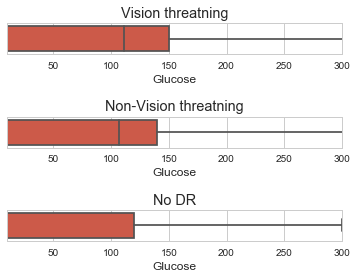

In [16]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
glu1 = latest_encounter.Glucose[latest_encounter.target_class == 1]
GLU1 = sns.boxplot(glu1)
GLU1.set(xlim=(10, 300))
GLU1.set_title('Vision threatning')
plt.subplot(312)
glu2 = latest_encounter.Glucose[latest_encounter.target_class == 2]
GLU2 = sns.boxplot(glu2)
GLU2.set(xlim=(10, 300))
GLU2.set_title('Non-Vision threatning')
plt.subplot(313)
glu3 = latest_encounter.Glucose[latest_encounter.target_class == 3]
GLU3 = sns.boxplot(glu3)
GLU3.set(xlim=(10, 300))
# BPU3.set(xlim=(10, 70))
GLU3.set_title('No DR')

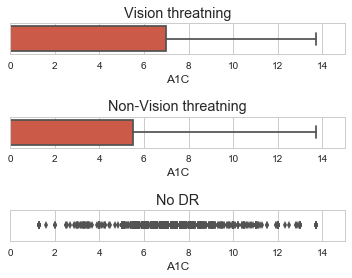

In [17]:
plt.subplots_adjust(hspace=2)
sns.set_style("whitegrid")
plt.subplot(311)
a1c1 = latest_encounter.A1C[latest_encounter.target_class == 1]
A1C1 = sns.boxplot(a1c1)
A1C1.set(xlim=(0, 15))
A1C1.set_title('Vision threatning')
plt.subplot(312)
a1c2 = latest_encounter.A1C[latest_encounter.target_class == 2]
A1C2 = sns.boxplot(a1c2)
A1C2.set(xlim=(0, 15))
A1C2.set_title('Non-Vision threatning')
plt.subplot(313)
a1c3 = latest_encounter.A1C[latest_encounter.target_class == 3]
A1C3 = sns.boxplot(a1c3)
A1C3.set(xlim=(0, 15))
# BPU3.set(xlim=(10, 70))
A1C3.set_title('No DR')

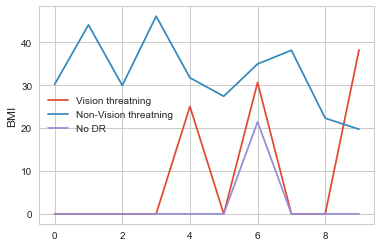

In [18]:
# y = latest_encounter.BMI
# from scipy.interpolate import spline
np.random.seed(1635)
x1 = random.sample(bmi1,10)
x2 = random.sample(bmi2,10)
x3 = random.sample(bmi3,10)
plt.ylabel('BMI')
plt.plot(x1, label='Vision threatning')
plt.plot(x2, label='Non-Vision threatning')
plt.plot(x3, label='No DR')
# sns.regplot(x='A1C',y='target_class',data = latest_encounter)
plt.legend()

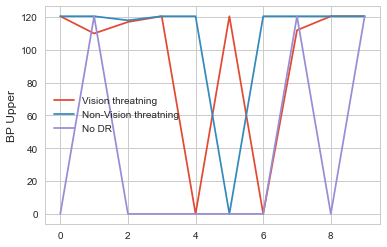

In [19]:
np.random.seed(1635)
x1 = random.sample(bpu1,10)
x2 = random.sample(bpu2,10)
x3 = random.sample(bpu3,10)
plt.ylabel('BP Upper')
plt.plot(x1, label='Vision threatning')
plt.plot(x2, label='Non-Vision threatning')
plt.plot(x3, label='No DR')
# sns.regplot(x='A1C',y='target_class',data = latest_encounter)
plt.legend()

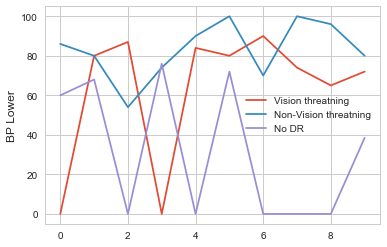

In [20]:
np.random.seed(1635)
x1 = random.sample(bpl1,10)
x2 = random.sample(bpl2,10)
x3 = random.sample(bpl3,10)
plt.ylabel('BP Lower')
plt.plot(x1, label='Vision threatning')
plt.plot(x2, label='Non-Vision threatning')
plt.plot(x3, label='No DR')
# sns.regplot(x='A1C',y='target_class',data = latest_encounter)
plt.legend()

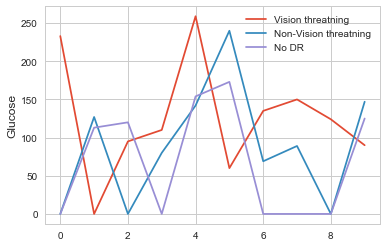

In [21]:
np.random.seed(1635)
x1 = random.sample(glu1,10)
x2 = random.sample(glu2,10)
x3 = random.sample(glu3,10)
plt.ylabel('Glucose')
plt.plot(x1, label='Vision threatning')
plt.plot(x2, label='Non-Vision threatning')
plt.plot(x3, label='No DR')
# sns.regplot(x='A1C',y='target_class',data = latest_encounter)
plt.legend()

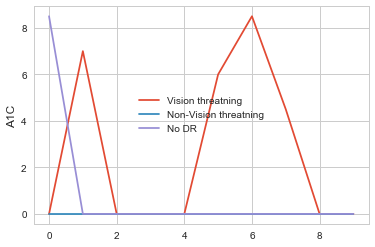

In [22]:
np.random.seed(1635)
x1 = random.sample(a1c1,10)
x2 = random.sample(a1c2,10)
x3 = random.sample(a1c3,10)
plt.ylabel('A1C')
plt.plot(x1, label='Vision threatning')
plt.plot(x2, label='Non-Vision threatning')
plt.plot(x3, label='No DR')
# sns.regplot(x='A1C',y='target_class',data = latest_encounter)
plt.legend()

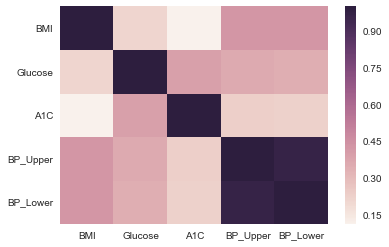

In [23]:
# latest_encounter.BMI.corr(latest_encounter.A1C)
corr = latest_encounter.iloc[:,[8,9,10,11,42,43]].corr()
sns.heatmap(corr)

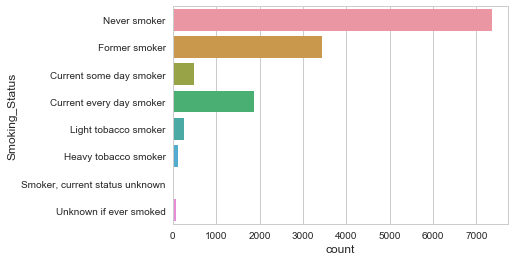

In [24]:
latest_encounter.replace(to_replace='Never Smoker',value='Never smoker',inplace=True,axis='Smoking_Status')
smoking_status = sns.countplot(y="Smoking_Status", data=latest_encounter,orient="v")

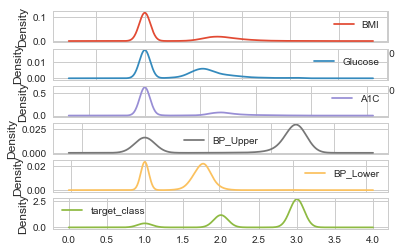

In [25]:
# latest_encounter.hist()
plt.subplots_adjust(hspace=2)
x = latest_encounter.iloc[:,[8,9,10,11,42,43,44]].plot(kind='density', subplots=True, sharex=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131b7e150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13322a810>]], dtype=object)

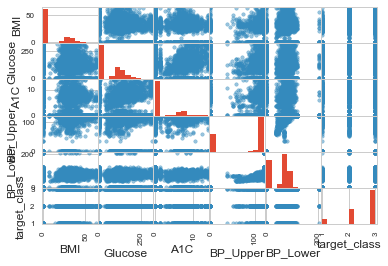

In [26]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(latest_encounter.iloc[:,[8,9,10,11,42,43,44]])

In [27]:
dr_data = pd.DataFrame(latest_encounter.iloc[:,[8,10,11,42,43,44,45,46,47,48,49]])

print(dr_data.shape)

(16087, 11)


In [28]:
#descriptions
print(dr_data.describe())

                BMI       Glucose           A1C      BP_Upper      BP_Lower  \
count  16087.000000  16087.000000  16087.000000  16087.000000  16087.000000   
mean      10.662745     70.216114      1.758630     79.374763     52.758129   
std       16.040521     77.458538      3.293766     55.548535     38.224893   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000     56.000000      0.000000    120.000000     70.000000   
75%       26.950000    129.000000      0.000000    120.500000     82.000000   
max       62.760000    314.500000     13.700000    120.500000    206.000000   

       target_class   BMI_Missing  BP_Upper_Missing  BP_Lower_Missing  \
count  16087.000000  16087.000000      16087.000000      16087.000000   
mean       2.543296      0.325232          0.673898          0.673898   
std        0.654824      0.468476          0.468800          0.468800

In [29]:
# Class Distribution
# 1 = Vision Threatening
# 2 = Non Vision Threatening
# 3 = No DR

print(dr_data.groupby('target_class').size())

target_class
1.0     1453
2.0     4441
3.0    10193
dtype: int64


In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [31]:
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter
# array = dr_data.values
# X = array[:,0:5]
# Y = array[:,5]
X = dr_data.iloc[:,[0,1,2,3,4,6,7,8,9,10]].values
Y = dr_data.iloc[:,[5]].values
ros = RandomOverSampler(random_state=42)
X, Y = ros.fit_sample(X, Y)
# print('Resampled dataset shape {}'.format(Counter(Y)))

ImportError: No module named imblearn.over_sampling

In [ ]:
# # Split-out validation dataset
# #from sklearn import model_selection
# # dr_data.iloc[:,[0]]
# array = dr_data.values
# X = dr_data.iloc[:,[0,1,2,3,4,6,7,8,9,10]].values
# Y = dr_data.iloc[:,[5]].values
# # X = array[:,0:5]
# # Y = array[:,5]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [ ]:
# dr_data.iloc[:,[0,1,2,3,4,6,7,8,9,10]].values
# # dr_data.head()
# dr_data.iloc[:,[5]].values

In [ ]:
scoring = 'accuracy'
# 6 Algorithms need to be checked to test most suitable accurate model
models = []
models.append(('Logistic Regression', LogisticRegression()))
# models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
# models.append(('K Nearest Neighbours', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier()))
models.append(('Support Vector Machine', SVC()))

# evaluate each model in turn
results = []
names = []

#Features are weighted
# weight_mat = np.array([[9,0,0,0,0],[0,5,0,0,0],[0,0,20,0,0],[0,0,0,1,0],[0,0,0,0,2]])

# X_train_weighted = np.matmul(X_train ,weight_mat)

sample_wt = np.array([5 if target_class == 1 else 1 for target_class in Y_train])

clf = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
kfold = model_selection.KFold(n_splits=10, random_state=seed)
scores = model_selection.cross_val_score(clf, X_train, Y_train, cv=kfold, scoring=scoring)

print "****Cross Validation Phase for ( Random Forest Classifier ) ********"
print "Cross Validation Accuracy Score mean = %f " % (scores.mean())
print "Cross Validation Accuracy Score Standard Deviation = %f " % (scores.std())

# dt = clf.fit(X_train, Y_train)
#Fitting Model
dt = clf.fit(X_train, Y_train, sample_weight=sample_wt)
predictions = clf.predict(X_validation)

print "**** Prediction metrics on Test Set for ( Random Forest Classifier )*****"
print("Accuracy Score on Test Data :")
print(accuracy_score(Y_validation, predictions))
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report:")
print(classification_report(Y_validation, predictions))
title = "Learning Curves"
print "**** Learning Curve for ( Random Forest Classifier ) ********"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(clf, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()   

for name, model in models:
    
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print "****Cross Validation Phase for ( %s ) ********" % (name)
    print "Cross Validation Accuracy Score mean = %f " % (cv_results.mean())
    print "Cross Validation Accuracy Score Standard Deviation = %f " % (cv_results.std())
    
    nb = model
#     dt = nb.fit(X_train, Y_train)
    dt = nb.fit(X_train, Y_train, sample_wt)
    predictions = nb.predict(X_validation)
    print "**** Prediction metrics on Test Set for ( %s )*****" % (name)
    print("Accuracy Score on Test Data :")
    print(accuracy_score(Y_validation, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(Y_validation, predictions))
    print("Classification Report:")
    print(classification_report(Y_validation, predictions))
    title = "Learning Curves"
    print "**** Learning Curve for ( %s ) ********" % (name)
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    plot_learning_curve(model, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
    plt.show()

In [ ]:
# Feature importances ranking with forests of trees

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, Y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

features = list(dr_data)
features = features[:-1]
print "All Features"
print features
print "\n"
# Print the feature ranking
print("Feature ranking:")
rankedFeatures = []
for f in range(X.shape[1]):
    print("%d. feature %d | (%s) | (%f)" % (f + 1, indices[f],features[indices[f]], importances[indices[f]]))
    rankedFeatures.append(features[indices[f]])

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), rankedFeatures)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# Naive Bayes Classification with feature weighting method
#BMI , Glucose , A1C , Systolic , Distolic
# weight_mat = np.array([[9,0,0,0,0],[0,5,0,0,0],[0,0,20,0,0],[0,0,0,1,0],[0,0,0,0,2]])
model = GaussianNB()

#Features are weighted
# X_train_weighted = np.matmul(X_train ,weight_mat)

sample_wt = np.array([5 if target_class == 1 else 1 for target_class in Y_train])

#Fit the model
#model.fit(X_train_weighted, Y_train,sample_wt)
print "****Cross Validation Phase for ( Naive Bayes ) ********"
    
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)

print "Cross Validation Accuracy Score mean = %f " % (cv_results.mean())
print "Cross Validation Accuracy Score Standard Deviation = %f " % (cv_results.std())

#Fitting Model
model.fit(X_train, Y_train, sample_wt)

#summarization of Naive Bayes
#Features are weighted
#X_validation_weighted = np.matmul(X_validation ,weight_mat)
#predictions = model.predict(X_validation_weighted)

predictions = model.predict(X_validation)
print "**** Prediction metrics on Test Set for ( Naive Bayes )*****"
print("Accuracy Score on Test Data :")
print(accuracy_score(Y_validation, predictions))
print("Confusion Matrix:")
print(confusion_matrix(Y_validation, predictions))
print("Classification Report:")
print(classification_report(Y_validation, predictions))
title = "Learning Curves"
print "**** Learning Curve for ( Naive Bayes ) ********"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(model, title, X, Y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

In [ ]:
#Decision Tree Classifier seems to have highest score among all 6 models
#Hence Decision Tree Classifier is the best model to fit into this dataset

In [ ]:
# Make predictions on validation dataset
nb = DecisionTreeClassifier()
dt = nb.fit(X_train, Y_train)

features = list(dr_data)
features = features[:-1]
#print features
classes = dt.classes_
#print classes
#Tree stored into dr.dot
tree.export_graphviz(dt, out_file='dr.dot', feature_names=features)

#%dot -Tpng dt.dot -o dt.png 
predictions = nb.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

In [ ]:
# The Accuracy Prediction is 97 %
# fitctree shown here https://www.mathworks.com/help/stats/fitctree.html?requestedDomain=www.mathworks.com
# This is to handle missing values with surrogate split technique